In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set the env var for the json file path
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!ls

drive  sample_data


In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 731M/745M [00:04<00:00, 174MB/s]
100% 745M/745M [00:04<00:00, 169MB/s]


In [ ]:
!unzip -q covid19-radiography-database.zip

In [ ]:
import numpy as np
import pandas as pd
import shutil
import random
import os

import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalMaxPooling2D, Conv1D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.keras import *
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import itertools
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
folders = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
base_folder = '/content/COVID-19_Radiography_Dataset'
data = []
labels = []

for folder in folders :
  files = os.listdir(os.path.join(base_folder, folder))
  for file in files:
    # some solutions here
    # read in gray
    img = cv2.imread(os.path.join(base_folder, folder, file),0)
    # resize to smaller images
    img = cv2.resize(img, (112, 112))
    data.append(img)
    labels.append(folder)


Text(0.5, 1.0, 'COVID')

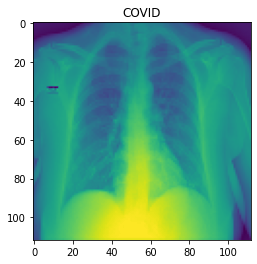

In [ ]:
plt.imshow(data[1])
plt.title(labels[1])

In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
np.unique(labels)

array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], dtype='<U15')

In [ ]:
print(data.shape)
print(labels.shape)

(21165, 112, 112)
(21165,)


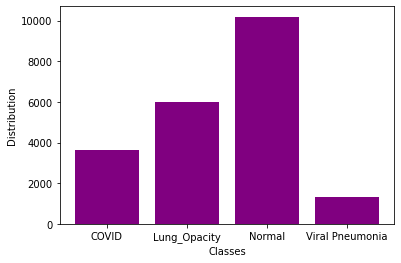

In [ ]:
CLASSES = np.unique(labels)
count = []
for cl in CLASSES:
  count.append(np.sum(labels == cl))

x = list(CLASSES)
plt.bar(x, count, color="purple")
plt.xlabel("Classes")
plt.ylabel("Distribution")
plt.show()


In [ ]:
# extra dim for training
data = data.reshape(-1, 112, 112, 1)

In [ ]:
data = data / 255.0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, 
                                                    labels,
                                                    stratify=labels,
                                                    random_state=42,
                                                    shuffle=True)
print(X_train.shape)
print(X_test.shape)

(15873, 112, 112, 1)
(5292, 112, 112, 1)


In [ ]:
encode = LabelEncoder()
onehotencoder = OneHotEncoder()

Y_train = encode.fit_transform(Y_train)
train_labels = Y_train.reshape(-1,1)
train_labels

Y_test = encode.transform(Y_test)
test_labels = Y_test.reshape(-1,1)
test_labels

array([[2],
       [1],
       [1],
       ...,
       [3],
       [2],
       [2]])

In [ ]:
Y_train = onehotencoder.fit_transform(train_labels)
Y_train = Y_train.toarray()

Y_test = onehotencoder.transform(test_labels)
Y_test = Y_test.toarray()
Y_test

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [ ]:
# the issue here is we cant use pretrained weights anymore
# unless the channel is created before the pretrained vgg
# using a 1x1 conv with 3 filters

mobile = MobileNetV2(input_shape= (112,112,3),  include_top=False , weights="imagenet", pooling='max')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
mobile.trainable = False

In [ ]:
model = Sequential()

model.add(Conv1D(3, 1, activation='relu', padding='same', input_shape=(112, 112, 1)))
model.add(mobile)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 112, 112, 3)       6         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 2,422,474
Trainable params: 164,490
Non-trainable params: 2,257,984
________________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(test_labels),
                                                 test_labels[:,0])

class_weights = {i: class_weights[i] for i in range(0, len(class_weights))}
print(class_weights)

{0: 1.4634955752212389, 1: 0.8802395209580839, 2: 0.5190270694389957, 3: 3.9375}


In [ ]:
res = model.fit(X_train, Y_train, batch_size=512 , epochs=20 , validation_data = (X_test, Y_test), class_weight= class_weights )

Epoch 1/20
32/32 [==============================] - 81s 1s/step - loss: 1.1973 - acc: 0.5771 - val_loss: 0.8225 - val_acc: 0.6782
Epoch 2/20
32/32 [==============================] - 40s 1s/step - loss: 0.6249 - acc: 0.7033 - val_loss: 0.6519 - val_acc: 0.7421
Epoch 3/20
32/32 [==============================] - 40s 1s/step - loss: 0.5308 - acc: 0.7515 - val_loss: 0.6094 - val_acc: 0.7604
Epoch 4/20
32/32 [==============================] - 40s 1s/step - loss: 0.5018 - acc: 0.7699 - val_loss: 0.6027 - val_acc: 0.7712
Epoch 5/20
32/32 [==============================] - 40s 1s/step - loss: 0.4725 - acc: 0.7726 - val_loss: 0.5144 - val_acc: 0.7963
Epoch 6/20
32/32 [==============================] - 40s 1s/step - loss: 0.4823 - acc: 0.7759 - val_loss: 0.5495 - val_acc: 0.7867
Epoch 7/20
32/32 [==============================] - 40s 1s/step - loss: 0.4113 - acc: 0.8097 - val_loss: 0.5307 - val_acc: 0.7937
Epoch 8/20
32/32 [==============================] - 40s 1s/step - loss: 0.3765 - acc: 0.82

In [ ]:
def print_details(train_data,validation_data,tr_label,val_label,history, test_predictions):
  print(classification_report(backend.argmax(val_label).numpy(),backend.argmax(test_predictions).numpy()))
  plt.plot(history.history['loss'], 'r-o')
  plt.plot(history.history['val_loss'], 'b--o')
  plt.title('Loss')
  plt.show()

  plt.plot(history.history['acc'], 'r-o')
  plt.plot(history.history['val_acc'], 'b--o')
  plt.title('Accuracy')
  plt.show()

  classes = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
  cm = confusion_matrix(backend.argmax(val_label).numpy(),backend.argmax(test_predictions).numpy())
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(4)

  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       904
           1       0.67      0.88      0.76      1503
           2       0.93      0.71      0.81      2549
           3       0.80      0.93      0.86       336

    accuracy                           0.79      5292
   macro avg       0.79      0.84      0.81      5292
weighted avg       0.82      0.79      0.80      5292



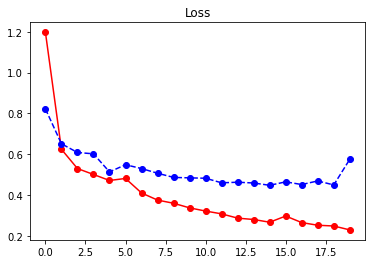

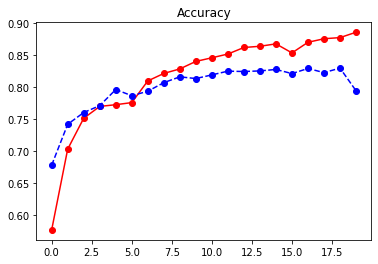

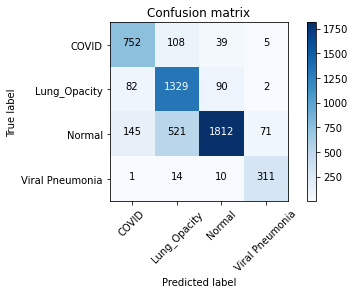

In [ ]:
print_details(X_train, X_test, Y_train, Y_test, res, model.predict(X_test))

In [ ]:
images = preprocess_input(data)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(images, 
                                                    labels,
                                                    stratify=labels,
                                                    random_state=42,
                                                    shuffle=True)
print(X_train.shape)
print(X_test.shape)

(15873, 112, 112, 1)
(5292, 112, 112, 1)


In [ ]:
encode = LabelEncoder()
onehotencoder = OneHotEncoder()

Y_train = encode.fit_transform(Y_train)
train_labels = Y_train.reshape(-1,1)
train_labels

Y_test = encode.transform(Y_test)
test_labels = Y_test.reshape(-1,1)
test_labels

array([[2],
       [1],
       [1],
       ...,
       [3],
       [2],
       [2]])

In [ ]:
Y_train = onehotencoder.fit_transform(train_labels)
Y_train = Y_train.toarray()

Y_test = onehotencoder.transform(test_labels)
Y_test = Y_test.toarray()
Y_test

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [ ]:
efficientNet = EfficientNetB0(input_shape=(112,112,3), include_top=False, weights='imagenet', pooling='max')

In [ ]:
efficientNet.trainable=False

In [ ]:
second_model = Sequential()

second_model.add(Conv1D(3, 1, activation='relu', padding='same', input_shape=(112, 112, 1)))
second_model.add(efficientNet)
second_model.add(Flatten())
second_model.add(Dense(128, activation='relu'))
second_model.add(Dropout(0.2))
second_model.add(Dense(4, activation='sigmoid'))


In [ ]:
second_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 112, 112, 3)       6         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 4,214,061
Trainable params: 164,490
Non-trainable params: 4,049,571
______________________________________

In [ ]:
second_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = second_model.fit(X_train, Y_train, batch_size=512 , epochs=20 , validation_data = (X_test, Y_test), class_weight= class_weights )

Epoch 1/20
32/32 [==============================] - 76s 2s/step - loss: 1.0372 - acc: 0.5908 - val_loss: 0.6569 - val_acc: 0.7436
Epoch 2/20
32/32 [==============================] - 63s 2s/step - loss: 0.5703 - acc: 0.7507 - val_loss: 0.5371 - val_acc: 0.8067
Epoch 3/20
32/32 [==============================] - 63s 2s/step - loss: 0.5014 - acc: 0.7835 - val_loss: 0.4980 - val_acc: 0.8099
Epoch 4/20
32/32 [==============================] - 63s 2s/step - loss: 0.4441 - acc: 0.8021 - val_loss: 0.4385 - val_acc: 0.8297
Epoch 5/20
32/32 [==============================] - 63s 2s/step - loss: 0.4272 - acc: 0.8089 - val_loss: 0.4199 - val_acc: 0.8365
Epoch 6/20
32/32 [==============================] - 64s 2s/step - loss: 0.4555 - acc: 0.7975 - val_loss: 0.4614 - val_acc: 0.8246
Epoch 7/20
32/32 [==============================] - 64s 2s/step - loss: 0.3848 - acc: 0.8242 - val_loss: 0.4362 - val_acc: 0.8347
Epoch 8/20
32/32 [==============================] - 63s 2s/step - loss: 0.3695 - acc: 0.83

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       904
           1       0.90      0.71      0.79      1503
           2       0.87      0.90      0.89      2549
           3       0.87      0.97      0.92       336

    accuracy                           0.85      5292
   macro avg       0.85      0.87      0.86      5292
weighted avg       0.86      0.85      0.85      5292



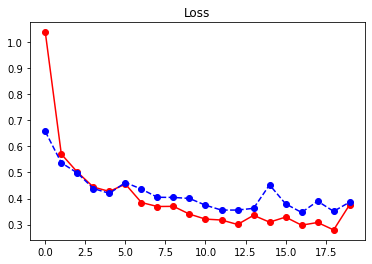

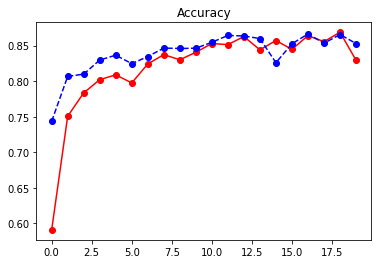

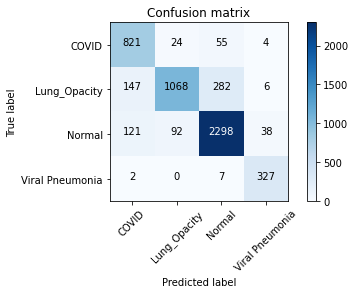

In [ ]:
print_details(X_train, X_test, Y_train, Y_test, history, second_model.predict(X_test))

In [ ]:
model.save('first_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
second_model.save('second_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
